### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### Dowlining Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('drive/My Drive/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip "/content/drive/My Drive/AFLW2000-3D.zip" -d "/content/drive/My Drive"

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

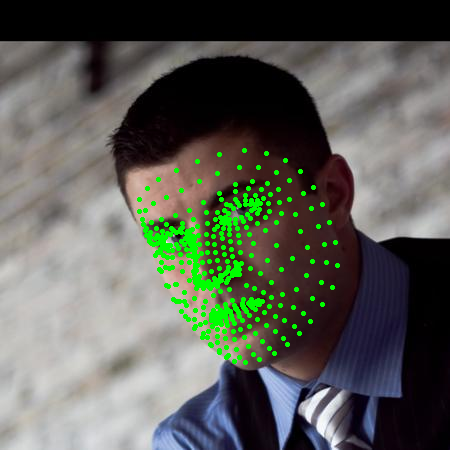

In [5]:
# choosing random image
random_file = 'image00020'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/drive/My Drive/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          row = []
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              row.append(relative_x)
              row.append(relative_y)
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              #print(relative_x, relative_y)
      cv2_imshow(image) 
      

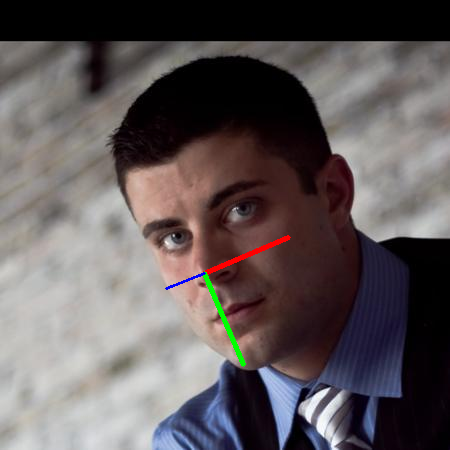

In [6]:
image = cv2.imread('/content/drive/My Drive/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/drive/My Drive/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll,row[8], row[9]))

### Extract features and labels from dataset

In [9]:
file_names = sorted([Path(f).stem for f in glob.glob("/content/drive/My Drive/AFLW2000/*.jpg")])
file_names_mat = sorted([Path(f).stem for f in glob.glob("/content/drive/My Drive/AFLW2000/*.mat")])

Xlist = []
Ylist = []
Angles = []

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/drive/My Drive/AFLW2000/'+ filename +'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        X = []
        Y = []
        for landmark in face.landmark:
          x = landmark.x
          y = landmark.y
          # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
          shape = image.shape 
          relative_x = int(x * shape[1])
          relative_y = int(y * shape[0])
          X.append(relative_x)
          Y.append(relative_y)
          # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)

        X = np.array(X)
        Y = np.array(Y)

        Xlist.append(X)
        Ylist.append(Y)
        
        mat_file = sio.loadmat('/content/drive/My Drive/AFLW2000/'+filename+'.mat')
        # extracting the labels 3 angels
        pose_para = mat_file["Pose_Para"][0][:3]
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2]
        Angles.append(np.array([pitch, yaw, roll]))


Xarray = np.array(Xlist)
Yarray = np.array(Ylist)
Angles_arr = np.array(Angles)

features = np.concatenate((Xarray,Yarray),axis = 1)

In [10]:
X_center = Xarray - Xarray[:,100].reshape(-1,1)
Y_center = Yarray - Yarray[:,100].reshape(-1,1)

X_100 = Xarray[:,100]
X_10 = Xarray[:,10]
Y_100 = Yarray[:,100]
Y_10 = Yarray[:,10]

# computing the distance
norm_term = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_100,Y_100)),axis = 0).reshape(-1,1)
X_norm = X_center / norm_term
Y_norm = Y_center / norm_term

features = np.concatenate((X_norm,Y_norm),axis =1)
print(features.shape)

(1853, 936)


In [11]:
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.240098,0.257248,0.257248,0.214373,0.257248,0.274398,0.308697,-0.231523,0.325847,0.334422,...,0.403022,0.377297,0.385872,0.411597,0.420172,-0.197223,-0.171499,-0.137199,-0.248673,-0.282973
1,-0.123299,-0.273998,-0.082199,-0.150699,-0.273998,-0.205499,0.013700,0.013700,0.082199,0.068500,...,0.301398,0.287698,0.369898,0.315098,0.342498,-0.260298,-0.232899,-0.219199,-0.301398,-0.342498
2,0.405820,0.427179,0.405820,0.320384,0.427179,0.427179,0.384461,-0.277666,0.363102,0.363102,...,0.299025,0.277666,0.277666,0.320384,0.320384,-0.256307,-0.234948,-0.213589,-0.320384,-0.341743
3,0.386005,0.225170,0.321671,0.096501,0.182280,0.160835,0.139391,-0.300226,0.064334,0.021445,...,0.289504,0.246614,0.214447,0.310948,0.310948,-0.418172,-0.375283,-0.332393,-0.632619,-0.686231
4,0.369755,0.293908,0.322351,0.189618,0.274946,0.255985,0.218061,-0.274946,0.189618,0.170656,...,0.189618,0.151695,0.189618,0.199099,0.218061,-0.350794,-0.322351,-0.303389,-0.474045,-0.493007


In [12]:
labels = pd.DataFrame(Angles_arr,columns = ['pitch', 'yaw', 'roll'])
labels.head()

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662


### Split and Train our model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV

In [14]:
X_train, X_valid, Y_train, Y_valid = train_test_split( features , labels, test_size=0.2, random_state=40)

In [15]:
svr_paramerters = { 'kernel':['poly', 'rbf', 'sigmoid'],
                   'C': [0.01,0.1,1,10,100],
                   'epsilon': [0.01,0.1,1,10,100]}

svr = SVR()
svr_model1 = GridSearchCV(estimator= svr, param_grid=svr_paramerters)
svr_model1.fit(X_train,Y_train[['pitch']])

svr_pitch_winner = svr_model1.best_estimator_

print("Pitch Wineer model: ",svr_pitch_winner)
print("MAE Training",MAE(svr_pitch_winner.predict(X_train), Y_train[['pitch']]))
print("MAE validation", MAE(svr_pitch_winner.predict(X_valid), Y_valid[['pitch']]))

Pitch Wineer model:  SVR(C=10, epsilon=0.01, kernel='poly')
MAE Training 0.09592138996672156
MAE validation 0.07906811424567871


In [16]:
svr_model2 = GridSearchCV(estimator= svr, param_grid=svr_paramerters)
svr_model2.fit(X_train,Y_train[['yaw']])

svr_yaw_winner = svr_model2.best_estimator_

print("Yaw Wineer model: ",svr_yaw_winner)
print("MAE Training", MAE(svr_yaw_winner.predict(X_train), Y_train[['yaw']]))
print("MAE validation", MAE(svr_yaw_winner.predict(X_valid), Y_valid[['yaw']]))

Yaw Wineer model:  SVR(C=100, epsilon=0.01, kernel='poly')
MAE Training 0.05046119356028019
MAE validation 0.06644477497013089


In [17]:
svr_model3 = GridSearchCV(estimator= svr, param_grid=svr_paramerters)
svr_model3.fit(X_train,Y_train[['roll']])

svr_roll_winner = svr_model3.best_estimator_

print("Roll Wineer model",svr_roll_winner)
print("MAE Training", MAE(svr_roll_winner.predict(X_train), Y_train[['roll']]))
print("MAE validation", MAE(svr_roll_winner.predict(X_valid), Y_valid[['roll']]))

Roll Wineer model SVR(C=100, epsilon=0.01)
MAE Training 0.05857959265642441
MAE validation 0.05079431034804761


### Test our on video and show some output frames

In [20]:
cap = cv2.VideoCapture('/content/drive/My Drive/MLvideo.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('/content/drive/My Drive/MLv.mp4',fourcc, 20.0, (height,width))

img_array=[]
while(cap.isOpened()):
  ret, frame = cap.read()
  frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
  if ret==True:
    with faceModule.FaceMesh(static_image_mode=True) as face:
      # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
      results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None:
        for face in results.multi_face_landmarks:
          X = []
          Y = []
          for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            X.append(relative_x)
            Y.append(relative_y)
        
          X = np.array(X)
          Y = np.array(Y)
          # centering the data arround the point 100
          X_center = X - X[100]
          Y_center = Y - Y[100]
           
          norm_term = np.linalg.norm(np.array((X[100],Y[100])) - np.array((X[10],Y[10])))
          X_norm = X_center/ norm_term
          Y_norm = Y_center/ norm_term
          features = np.concatenate((X_norm,Y_norm), axis = 0).reshape(1,-1)
          # predicting the 3 angels to draw the axis on the image

          pitch = svr_pitch_winner.predict(features)
          yaw = svr_yaw_winner.predict(features)
          roll = svr_roll_winner.predict(features)
          draw_axis(frame,pitch, yaw,roll,X[1],Y[1])
          
          img_array.append(frame)
  else: 
    break

cap.release()  

for i in range(len(img_array)):
  out.write(img_array[i])
out.release()
cv2.destroyAllWindows()

print("Num of frames",len(img_array))

Num of frames 758


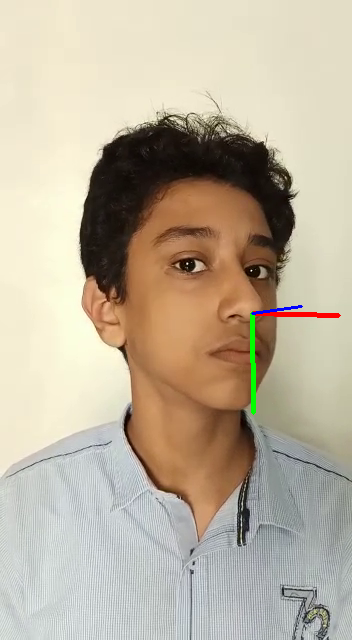

In [36]:
cv2_imshow(img_array[100])

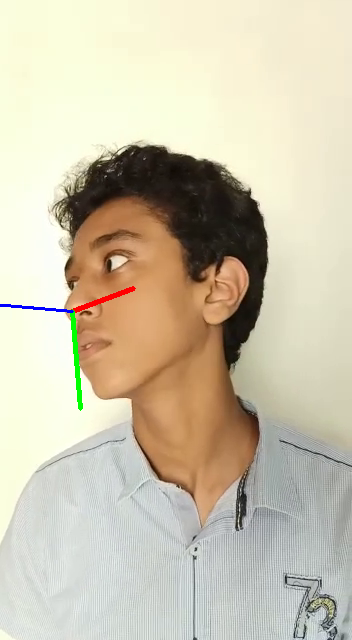

In [27]:
cv2_imshow(img_array[410])

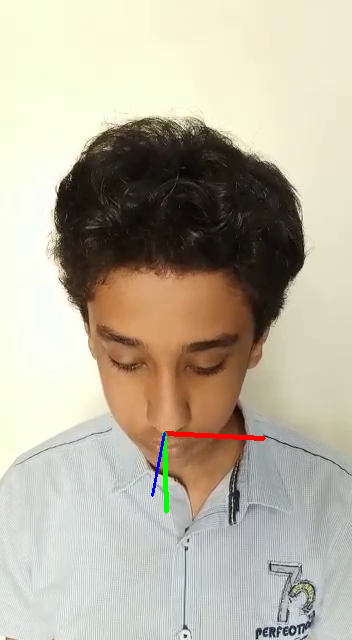

In [29]:
cv2_imshow(img_array[590])

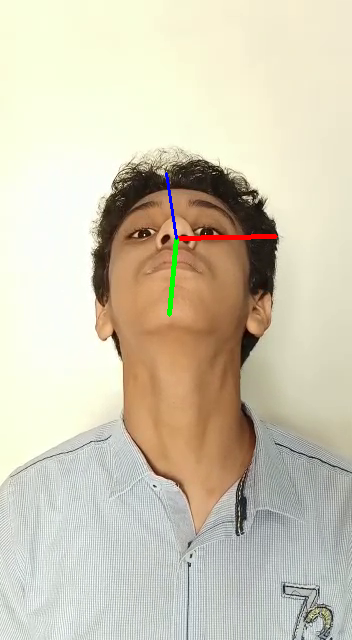

In [31]:
cv2_imshow(img_array[712])

In [22]:
from google.colab import files
files.download('/content/drive/My Drive/MLv.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>